# 모델2
- 텍스트를 보고 후보자 예측
- 입력 데이터(Feature)
    - 기사제목+댓글내용
- 출력 데이터(Label)
    - 박영선
    - 오세훈
    - 김영춘
    - 박형준

In [1]:
# 기본 라이브러리
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('seaborn-whitegrid')
import missingno
import re
import os
# 데이터
from sklearn.datasets import load_iris

# 경고메시지 제거
import warnings 
warnings.filterwarnings('ignore')

# KFold
from sklearn.model_selection import KFold # 순서대로 하거나 or 랜덤하게 클래스를 나눈다.
from sklearn.model_selection import StratifiedKFold # 결과데이터를 보고 각 클래스가 균등한 비율로 들어있게끔 나눈다.

# 교차검증 함수
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# 학습데이터와 검증데이터로 나누는 함수
from sklearn.model_selection import train_test_split

# 데이터 전처리
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# 하이퍼 파라미터 튜닝
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
    
# 머신러닝 알고리즘 - 분류
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
# 추가항목
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

# 머신러닝 알고리즘 - 회귀
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# 비지도학습 - 군집
from sklearn.cluster import KMeans
from sklearn.cluster import mean_shift

# 딥러닝
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf

# CNN
from keras.utils import np_utils
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D, Conv1D
from keras.layers import MaxPooling2D, MaxPooling1D

# NLP
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# 문장을 단어 단위로 나누기
from keras.preprocessing.text import text_to_word_sequence
from keras.layers import Embedding

# 다중분류를 위한 원-핫 인코더
from keras.utils import to_categorical

# 더이상 성능 향상이 이루어지지 않는다면 조기 중단시킬 수 있는 함수
from keras.callbacks import EarlyStopping

# epoch마다 모델을 저장하는 함수
from keras.callbacks import ModelCheckpoint

# 파일로 저장된 딥러닝 모델을 객체로 복구하는 함수
from keras.models import load_model

# 저장
import pickle

# 시간 모듈
import time # 현재 시간값을 구할 수 있다.

# 그래프 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 13
plt.rcParams['figure.figsize'] = 10,5
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# GPU 메모리 사용량을 필요한 만큼만 증가하도록 설정

# 사용가능한 GPU 목록 가져오기
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        # 필요한 만큼만 메모리를 사용할 수 있도록 설정하기
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# RandomSeed
np.random.seed(1)

## 1. 데이터 불러오기

In [4]:
df = pd.read_csv('./data/재보궐선거댓글데이터_최종_전처리완료.csv')
print(df.shape)
df.head()

(144139, 12)


,제목,날짜,작성일,댓글,출처,"지역(서울:1, 부산:2)","정당(1:더불어민주당,2:국민의힘)","정당평가(부정;0, 긍정:1)",후보(기호 순),"후보평가(부정;0, 긍정:1)",제목댓글,전처리 제목댓글
0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결?",2021-03-07 05:57:00,2021-03-12 19:13:00,철수야! 뜸 들이지 말고 애국하는 마음으로 물러서라~~~,조선일보,NaN,NaN,NaN,NaN,NaN,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 철수야! 뜸 들이...",재보궐 D31 부산 김영춘 vs 박형준 서울도 양자 대결 철수야 뜸 들이지 말고 애...
1,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결?",2021-03-07 05:57:00,2021-03-09 13:49:00,박영선은 정동영이 얻은 36프로선에 머무를것. 4.7.이후 OOO정권은 몰락의 길 ...,조선일보,1.0,NaN,NaN,1.0,0.0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 박영선은 정동영이...",재보궐 D31 부산 김영춘 vs 박형준 서울도 양자 대결 박영선은 정동영이 얻은 3...
2,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결?",2021-03-07 05:57:00,2021-03-07 14:42:00,빵선이가서울시장되면서울은공산국가수도제2의평양이될것이다,조선일보,1.0,NaN,NaN,1.0,0.0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 빵선이가서울시장되...",재보궐 D31 부산 김영춘 vs 박형준 서울도 양자 대결 빵 산 이가 서울시장 되면...
3,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결?",2021-03-07 05:57:00,2021-03-07 14:38:00,서울시장후보더듬당박빵선이는절대로서울시장을할수없다이유는가족은미국.영국에 영주권자이므로...,조선일보,1.0,1.0,0.0,1.0,0.0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 서울시장후보더듬당...",재보궐 D31 부산 김영춘 vs 박형준 서울도 양자 대결 서울시장 후보 더 든 대치...
4,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결?",2021-03-07 05:57:00,2021-03-07 14:02:00,부산은오거돈선거이고 오거돈치부선거아닌가 오거돈에 성추해으로 생긴선거가 가독도신공항은...,조선일보,2.0,1.0,0.0,NaN,NaN,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 부산은오거돈선거이...",재보궐 D31 부산 김영춘 vs 박형준 서울도 양자 대결 부산은 오거돈 선거이고 오...


## 2. 데이터 전처리
- 후보자별 데이터 분리

In [5]:
# 사용할 데이터
df2 = df[['지역(서울:1, 부산:2)', '후보(기호 순)', '후보평가(부정;0, 긍정:1)',
          '정당(1:더불어민주당,2:국민의힘)', '정당평가(부정;0, 긍정:1)', '전처리 제목댓글']]
df2.columns = ['area', 'candidate', 'candidate_eval',
               'party', 'party_eval', 'title_comment']

# 후보자를 구별하여 'area_candidate' 컬럼에 각 후보자 이름 추가

# 후보자별 인덱스 추출
ys_idx = df2.query('area == 1.0 & candidate == 1.0').index  # 박영선
sh_idx = df2.query('area == 1.0 & candidate == 2.0').index  # 오세훈
yc_idx = df2.query('area == 2.0 & candidate == 1.0').index  # 김영춘
hj_idx = df2.query('area == 2.0 & candidate == 2.0').index  # 박형준
etc_idx = df2.query('candidate == 5.0').index  # 기타

# 'area_candidate'컬럼에 후보자 이름값 추가
df2['area_candidate'] = np.nan
df2['area_candidate'][ys_idx] = '박영선'
df2['area_candidate'][sh_idx] = '오세훈'
df2['area_candidate'][yc_idx] = '김영춘'
df2['area_candidate'][hj_idx] = '박형준'
df2['area_candidate'][etc_idx] = '기타'

In [6]:
# 데이터 종류별 개수 확인
print(f'총 라벨링된 데이터수: {df2["area_candidate"].value_counts().sum()}')
pd.DataFrame(df2['area_candidate'].value_counts())

총 라벨링된 데이터수: 4332


,area_candidate
기타,1611
박영선,1303
오세훈,1178
박형준,211
김영춘,29


# 3. 다중분류
- **활성화 함수**를 **이용**하려면 Y값이 **0-1로 이루어져** 있어야 함
    - 원-핫 인코딩(One-Hot Encoding)

## 3.1 학습할 텍스트(docs) 지정

In [7]:
# 한글 정규표현식
def text_cleaning(text) :
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    result = hangul.sub('', str(text))
    return result

In [8]:
# 한글 외 문자열 공백처리
df2['title_comment'] = df2['title_comment'].apply(lambda x: text_cleaning(x))

In [9]:
# 후보자를 5가지로 분리가능한 데이터수
notnull_idx = df2[ df2['area_candidate'].notnull() ].index

# 후보자 예측에 사용될 feature 텍스트 선정
docs = df2['title_comment'][notnull_idx].to_list()
len(docs) # 총 라벨링된 데이터수랑 같아야함.

4332

## 3.2  y값 문자열 Encoding

In [10]:
# 문자열 인코딩
encoder = LabelEncoder()

# 후보값을 LabelEncoding
y = encoder.fit_transform(df2['area_candidate'][notnull_idx].values)
y

array([2, 2, 2, ..., 4, 0, 4])

In [11]:
# 인코딩값 확인
print( encoder.classes_ )
print( encoder.inverse_transform([0]) )
print( encoder.inverse_transform([1]) )
print( encoder.inverse_transform([2]) )
print( encoder.inverse_transform([3]) )
print( encoder.inverse_transform([4]) )

['기타' '김영춘' '박영선' '박형준' '오세훈']
['기타']
['김영춘']
['박영선']
['박형준']
['오세훈']


## 3.3  y값 One-Hot Encoding
- 출력층 node의 개수는 **5개**로 맞춰주기

In [12]:
y_encoded = to_categorical(y)
y_encoded.shape 

(4332, 5)

In [13]:
y_encoded # ⭐출력층 노드의 개수는 5로 맞춰주기⭐

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

## 3.4 Tokenizer
- 텍스트를 잘게 나누는 것
- 단어별, 문장별, 형태소별, ...
- 이렇게 나누어진 하나의 단위를 **Token(토큰)**


- **빈도에 따라 번호가 정해지도록 만들기**
    - Tokenizer(num_words=5000): 빈도가 높은 토큰들 중 5000개 토큰만 선택해서 가져오기

In [96]:
# 빈도가 높은 단어들로 구성
num_word = 5000

token = Tokenizer(num_words=num_word) # 토큰화 함수 지정
token.fit_on_texts(docs) # 토큰화 함수에 문장 적용
token.word_index # 각 단어에 매겨진 인덱스값 출력

{'박영선': 1,
 '오세훈': 2,
 '다': 3,
 '안철수': 4,
 '서울시장': 5,
 '문재인': 6,
 '한': 7,
 '안': 8,
 '후보': 9,
 '이': 10,
 '보궐선거': 11,
 '못': 12,
 '내곡동': 13,
 '단일화': 14,
 '땅': 15,
 '천안함': 16,
 '이게': 17,
 '유승민': 18,
 '참석': 19,
 '추모식': 20,
 '것': 21,
 '국민의': 22,
 '더불어민주당': 23,
 '대통령': 24,
 '후보자': 25,
 '토론회': 26,
 '나라냐': 27,
 '번': 28,
 '하태경': 29,
 '수': 30,
 '있는': 31,
 '토론': 32,
 '하는': 33,
 '그': 34,
 '년': 35,
 '박형준': 36,
 '다시': 37,
 '한다': 38,
 '선거': 39,
 '주영진의': 40,
 '뉴스브리핑': 41,
 '게': 42,
 '더': 43,
 '이런': 44,
 '할': 45,
 '회': 46,
 '당신의': 47,
 '서울': 48,
 '없는': 49,
 '선택은': 50,
 '분토론': 51,
 '또': 52,
 '왜': 53,
 '원인첫': 54,
 '어땠나': 55,
 '때': 56,
 '물었다': 57,
 '부산시장': 58,
 '것이다': 59,
 '야당': 60,
 '전': 61,
 '것이': 62,
 '건': 63,
 '와': 64,
 '사설': 65,
 '김어준': 66,
 '만': 67,
 '부산': 68,
 '등': 69,
 '김영춘': 70,
 '두': 71,
 '거': 72,
 '사저': 73,
 '되면': 74,
 '오세훈이': 75,
 '지혜원의': 76,
 '사저는': 77,
 '노무현의': 78,
 '구하기': 79,
 '하고': 80,
 '아방': 81,
 '시장': 82,
 '있다': 83,
 '친구가': 84,
 '일': 85,
 '이럽니까': 86,
 '같은': 87,
 '정치': 88,
 '참': 89,
 '선언':

In [97]:
len(token.word_index) # 전체 토큰 개수는 30503

30503

In [98]:
# 앞서 만든 토큰의 인덱스로만 채워진 새로운 배열 생성
X = token.texts_to_sequences(docs)
print(X[0])  # 토큰화 후 인덱스로 채워진 새로운 배열
print(docs[0])  # 토큰화 전 실제 문장의 배열

[785, 68, 70, 36, 1659, 1409, 1006, 479, 3316, 1221, 21, 1660, 682, 877, 59]
재보궐  부산 김영춘  박형준 서울도 양자 대결 박영선은 정동영이 얻은  프로 선에 머무를 것  이후  정권은 몰락의 길 페달을 급속히 밟을 것이다


### 🤗 문장별 토큰 개수 파악
- 최대 토큰수를 찾기 위해

In [99]:
# 각 토큰으로 채워진 배열에서 최대 토큰수 찾기
max_len = 0
for i in X:
    if max_len <= len(i):
        max_len = len(i)
        
max_len

529

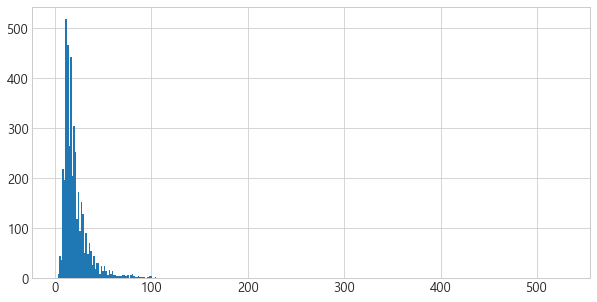

In [100]:
# 문장별 토큰 개수의 분포 확인
total_token_count = []
for i in X:
    total_token_count.append(len(i))

plt.hist( total_token_count, bins='auto' )
plt.show()

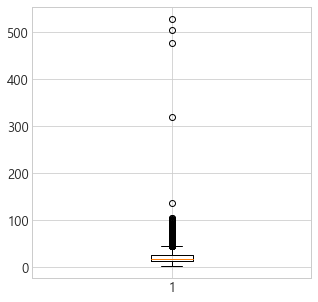

In [101]:
plt.figure(figsize=(5,5))
plt.boxplot(total_token_count)
plt.show() 

In [102]:
total_token_count.sort(reverse=True)
total_token_count[:10]

[529, 506, 477, 321, 136, 105, 105, 102, 101, 100]

- 한 문장의 최대 토큰개수인 [955, 944, 842, 529, 228]개는 극단치라고 볼 수 있음
- 토큰의 수가 [955, 944, 842, 529, 228]인 데이터 제외

In [103]:
# 토큰 개수의 분포 확인
pd.DataFrame(total_token_count, columns=['len(tokens)']).describe() 

,len(tokens)
count,4332.000000
mean,21.856879
std,19.303906
min,3.000000
25%,13.000000
50%,17.000000
75%,26.000000
max,529.000000


In [104]:
# 토큰 개수의 95% 확인
max_len = int(pd.Series(total_token_count).quantile(0.95) )
max_len

49

- **패딩(padding)** 시 맞춰주는 배열의 길이는 토큰의 최대길이 **163**로 맞춰준다.
- **임베딩(embedding)** 시 배열을 압축할 때 사용하는 길이는 전체 문장의 95%가 포함되어 있는 토큰의 수인 **70**를 사용하여 압축한다.

## 5. 패딩(Padding)
- **딥러닝 모델**에 **입력**을 하려면 **학습 데이터의 길이가 동일**해야함. 패딩은 길이를 맞춰주는 작업
- 원하는 길이보다 짧은 부분은 숫자 0을 넣어 채우고,긴 데이터는 잘라서 같은 길이로 맞춘다.
- 한 문장의 토큰 개수 합이 가장 많은 것으로 채우는 것이 좋다.
- 따라서, 서로 다른 길이의 데이터를 **163**로 맞춘다.

In [63]:
padded_x = pad_sequences(X, max_len)
padded_x # 배열의 길이가 맞춰짐

array([[   0,    0,    0, ...,  682,  877,   59],
       [   0,    0,    0, ..., 1661,  107,   59],
       [   0,    0,    0, ..., 1518, 2362, 4249],
       ...,
       [   0,    0,    0, ...,  752,   30,  580],
       [   0,    0,    0, ...,  829, 3269,   83],
       [   0,    0,    0, ...,    8,  197,  506]])

## 6. 임베딩(Embedding)
- **주어진 배열을 정해진 길이로 압축**
- 텍스트를 원-핫 인코딩 시 벡터의 길이가 너무 길어지는 문제 해결


- **Embedding**( 입력, 출력, 단어수 )
    - **입력**: 총 몇 개의 단어 집합
    - **출력**: 몇 개의 임베딩 결과 사용할 것인지(임의) -> 토큰 배열의 95%를 차지하는 70으로 설정
    - **단어수**: 매번 입력될 단어 수는 몇 개로 할 것인지

In [64]:
# 총 몇 개의 '인덱스'가 '입력' 되어야 하는지 정하기
word_size = len(token.word_index) + 1 # 전체 단어 맨 앞에 0이 먼저 나와야 함.
word_size

30504

## 7. 모델 구조 생성/학습 및 저장
- 1. 기본 딥러닝
- 2. RNN(Recurrent Neural network, RNN)
    - **여러개의 데이터가 순서대로 입력**되었을 때 앞서 입력받은 데이터를 **잠시 기억**해놓는 방법. 그리고 기억된 데이터가 얼마나 **중요한지를 판단**하여 **별도의 가중치**를 줘서 다음 데이터로 넘기게 됨
    - **LSTM(Long Short Term Memory)**
        - RNN의 기울기 소실 문제라는 단점을 보완한 방법
        - 즉, 반복되기 직전에 다음 층으로 기억된 값을 넘길지 안 넘길지를 관리하는 단계 추가
- 3. CNN과 LSTM

### 7.1 DNN

In [65]:
word_size = num_word

In [26]:
# DNN 설정
model = Sequential()
model.add(Embedding( num_word, 8 , input_length=max_len ) )
model.add(Flatten())
model.add(Dense(5, activation='softmax')) # 다중분류

# 모델 컴파일
model.compile( loss='categorical_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy']
             )

# 모델 저장 조건 설정
model_path = 'model/DNN_0511_2218/{epoch}-{val_loss}.h5'
checkpointer = ModelCheckpoint(filepath=model_path, monitor='val_loss', 
                               verbose=1,
                               save_best_only=True)
# 학습 자동 중단 설정
early_stopping_callback = EarlyStopping(monitor='val_loss',patience=300)

# 훈련 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(padded_x, 
                                                     y_encoded, 
                                                     test_size=0.2, 
                                                     stratify=y_encoded)


# 모델 실행 및 저장
history = model.fit( X_train, y_train, validation_split=0.2,
                    epochs=1500,
                    callbacks=[early_stopping_callback, checkpointer])

Epoch 1/1500
87/87 [==============================] - 2s 7ms/step - loss: 1.5023 - accuracy: 0.3195 - val_loss: 1.2728 - val_accuracy: 0.4704

Epoch 00001: val_loss improved from inf to 1.27280, saving model to model/DNN_0511_2218\1-1.2727967500686646.h5
Epoch 2/1500
87/87 [==============================] - 0s 3ms/step - loss: 1.2018 - accuracy: 0.5199 - val_loss: 1.1451 - val_accuracy: 0.5411

Epoch 00002: val_loss improved from 1.27280 to 1.14506, saving model to model/DNN_0511_2218\2-1.1450629234313965.h5
Epoch 3/1500
87/87 [==============================] - 0s 3ms/step - loss: 1.0558 - accuracy: 0.6036 - val_loss: 0.9976 - val_accuracy: 0.6277

Epoch 00003: val_loss improved from 1.14506 to 0.99756, saving model to model/DNN_0511_2218\3-0.997559666633606.h5
Epoch 4/1500
87/87 [==============================] - 0s 3ms/step - loss: 0.8602 - accuracy: 0.7178 - val_loss: 0.8761 - val_accuracy: 0.7215

Epoch 00004: val_loss improved from 0.99756 to 0.87610, saving model to model/DNN_051

87/87 [==============================] - 0s 4ms/step - loss: 0.0299 - accuracy: 0.9877 - val_loss: 0.7462 - val_accuracy: 0.8023

Epoch 00039: val_loss did not improve from 0.56944
Epoch 40/1500
87/87 [==============================] - 0s 3ms/step - loss: 0.0262 - accuracy: 0.9885 - val_loss: 0.7552 - val_accuracy: 0.8009

Epoch 00040: val_loss did not improve from 0.56944
Epoch 41/1500
87/87 [==============================] - 0s 3ms/step - loss: 0.0253 - accuracy: 0.9890 - val_loss: 0.7585 - val_accuracy: 0.7980

Epoch 00041: val_loss did not improve from 0.56944
Epoch 42/1500
87/87 [==============================] - 0s 3ms/step - loss: 0.0278 - accuracy: 0.9892 - val_loss: 0.7726 - val_accuracy: 0.8023

Epoch 00042: val_loss did not improve from 0.56944
Epoch 43/1500
87/87 [==============================] - 0s 3ms/step - loss: 0.0251 - accuracy: 0.9875 - val_loss: 0.7747 - val_accuracy: 0.7994

Epoch 00043: val_loss did not improve from 0.56944
Epoch 44/1500
87/87 [==================

87/87 [==============================] - 0s 3ms/step - loss: 0.0193 - accuracy: 0.9865 - val_loss: 0.9845 - val_accuracy: 0.7778

Epoch 00081: val_loss did not improve from 0.56944
Epoch 82/1500
87/87 [==============================] - 0s 3ms/step - loss: 0.0214 - accuracy: 0.9861 - val_loss: 0.9899 - val_accuracy: 0.7763

Epoch 00082: val_loss did not improve from 0.56944
Epoch 83/1500
87/87 [==============================] - 0s 3ms/step - loss: 0.0164 - accuracy: 0.9885 - val_loss: 0.9981 - val_accuracy: 0.7792

Epoch 00083: val_loss did not improve from 0.56944
Epoch 84/1500
87/87 [==============================] - 0s 3ms/step - loss: 0.0165 - accuracy: 0.9881 - val_loss: 1.0004 - val_accuracy: 0.7763

Epoch 00084: val_loss did not improve from 0.56944
Epoch 85/1500
87/87 [==============================] - 0s 3ms/step - loss: 0.0124 - accuracy: 0.9935 - val_loss: 1.0006 - val_accuracy: 0.7734

Epoch 00085: val_loss did not improve from 0.56944
Epoch 86/1500
87/87 [==================

87/87 [==============================] - 0s 3ms/step - loss: 0.0148 - accuracy: 0.9908 - val_loss: 1.1864 - val_accuracy: 0.7677

Epoch 00123: val_loss did not improve from 0.56944
Epoch 124/1500
87/87 [==============================] - 0s 3ms/step - loss: 0.0216 - accuracy: 0.9849 - val_loss: 1.1877 - val_accuracy: 0.7662

Epoch 00124: val_loss did not improve from 0.56944
Epoch 125/1500
87/87 [==============================] - 0s 3ms/step - loss: 0.0176 - accuracy: 0.9862 - val_loss: 1.1998 - val_accuracy: 0.7662

Epoch 00125: val_loss did not improve from 0.56944
Epoch 126/1500
87/87 [==============================] - 0s 4ms/step - loss: 0.0200 - accuracy: 0.9849 - val_loss: 1.2051 - val_accuracy: 0.7662

Epoch 00126: val_loss did not improve from 0.56944
Epoch 127/1500
87/87 [==============================] - 0s 4ms/step - loss: 0.0154 - accuracy: 0.9868 - val_loss: 1.2082 - val_accuracy: 0.7648

Epoch 00127: val_loss did not improve from 0.56944
Epoch 128/1500
87/87 [=============

87/87 [==============================] - 0s 4ms/step - loss: 0.0184 - accuracy: 0.9865 - val_loss: 1.4150 - val_accuracy: 0.7504

Epoch 00165: val_loss did not improve from 0.56944
Epoch 166/1500
87/87 [==============================] - 0s 4ms/step - loss: 0.0156 - accuracy: 0.9906 - val_loss: 1.4203 - val_accuracy: 0.7532

Epoch 00166: val_loss did not improve from 0.56944
Epoch 167/1500
87/87 [==============================] - 0s 4ms/step - loss: 0.0154 - accuracy: 0.9881 - val_loss: 1.4308 - val_accuracy: 0.7504

Epoch 00167: val_loss did not improve from 0.56944
Epoch 168/1500
87/87 [==============================] - 0s 4ms/step - loss: 0.0107 - accuracy: 0.9936 - val_loss: 1.4317 - val_accuracy: 0.7518

Epoch 00168: val_loss did not improve from 0.56944
Epoch 169/1500
87/87 [==============================] - 0s 4ms/step - loss: 0.0143 - accuracy: 0.9876 - val_loss: 1.4316 - val_accuracy: 0.7504

Epoch 00169: val_loss did not improve from 0.56944
Epoch 170/1500
87/87 [=============

87/87 [==============================] - 0s 3ms/step - loss: 0.0148 - accuracy: 0.9909 - val_loss: 1.6524 - val_accuracy: 0.7446

Epoch 00207: val_loss did not improve from 0.56944
Epoch 208/1500
87/87 [==============================] - 0s 3ms/step - loss: 0.0143 - accuracy: 0.9913 - val_loss: 1.6545 - val_accuracy: 0.7403

Epoch 00208: val_loss did not improve from 0.56944
Epoch 209/1500
87/87 [==============================] - 0s 3ms/step - loss: 0.0141 - accuracy: 0.9902 - val_loss: 1.6597 - val_accuracy: 0.7403

Epoch 00209: val_loss did not improve from 0.56944
Epoch 210/1500
87/87 [==============================] - 0s 3ms/step - loss: 0.0124 - accuracy: 0.9906 - val_loss: 1.6686 - val_accuracy: 0.7403

Epoch 00210: val_loss did not improve from 0.56944
Epoch 211/1500
87/87 [==============================] - 0s 3ms/step - loss: 0.0154 - accuracy: 0.9919 - val_loss: 1.6739 - val_accuracy: 0.7431

Epoch 00211: val_loss did not improve from 0.56944
Epoch 212/1500
87/87 [=============

87/87 [==============================] - 0s 3ms/step - loss: 0.0160 - accuracy: 0.9891 - val_loss: 1.8771 - val_accuracy: 0.7302

Epoch 00249: val_loss did not improve from 0.56944
Epoch 250/1500
87/87 [==============================] - 0s 3ms/step - loss: 0.0137 - accuracy: 0.9900 - val_loss: 1.8830 - val_accuracy: 0.7302

Epoch 00250: val_loss did not improve from 0.56944
Epoch 251/1500
87/87 [==============================] - 0s 3ms/step - loss: 0.0140 - accuracy: 0.9889 - val_loss: 1.8881 - val_accuracy: 0.7302

Epoch 00251: val_loss did not improve from 0.56944
Epoch 252/1500
87/87 [==============================] - 0s 3ms/step - loss: 0.0152 - accuracy: 0.9893 - val_loss: 1.8910 - val_accuracy: 0.7316

Epoch 00252: val_loss did not improve from 0.56944
Epoch 253/1500
87/87 [==============================] - 0s 3ms/step - loss: 0.0161 - accuracy: 0.9874 - val_loss: 1.8955 - val_accuracy: 0.7273

Epoch 00253: val_loss did not improve from 0.56944
Epoch 254/1500
87/87 [=============

87/87 [==============================] - 0s 3ms/step - loss: 0.0165 - accuracy: 0.9880 - val_loss: 2.0626 - val_accuracy: 0.7186

Epoch 00291: val_loss did not improve from 0.56944
Epoch 292/1500
87/87 [==============================] - 0s 3ms/step - loss: 0.0117 - accuracy: 0.9926 - val_loss: 2.0676 - val_accuracy: 0.7186

Epoch 00292: val_loss did not improve from 0.56944
Epoch 293/1500
87/87 [==============================] - 0s 3ms/step - loss: 0.0130 - accuracy: 0.9872 - val_loss: 2.0697 - val_accuracy: 0.7186

Epoch 00293: val_loss did not improve from 0.56944
Epoch 294/1500
87/87 [==============================] - 0s 3ms/step - loss: 0.0138 - accuracy: 0.9917 - val_loss: 2.0739 - val_accuracy: 0.7201

Epoch 00294: val_loss did not improve from 0.56944
Epoch 295/1500
87/87 [==============================] - 0s 3ms/step - loss: 0.0173 - accuracy: 0.9877 - val_loss: 2.0802 - val_accuracy: 0.7186

Epoch 00295: val_loss did not improve from 0.56944
Epoch 296/1500
87/87 [=============

In [27]:
# 모델 구조
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 43, 8)             24000     
_________________________________________________________________
flatten (Flatten)            (None, 344)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 1725      
Total params: 25,725
Trainable params: 25,725
Non-trainable params: 0
_________________________________________________________________


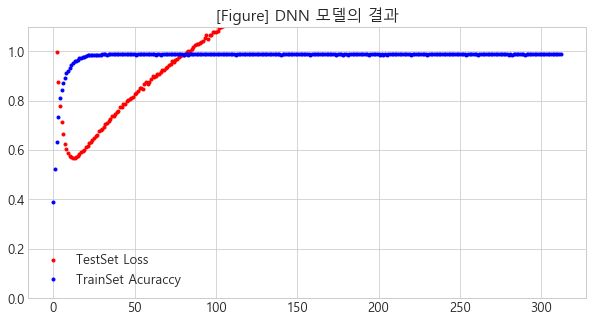

In [28]:
# 테스트셋으로 실험 결과의 오차값을 저장
y_vloss = history.history['val_loss']

# 학습셋으로 측정한 정확도의 값 저장
y_acc = history.history['accuracy']

# x값을 지정하고 그래프로 확인
x_len = np.arange(len(y_acc))
plt.title('[Figure] DNN 모델의 결과')
plt.plot( x_len, y_vloss, 'o', c='red', markersize=3, label='TestSet Loss')
plt.plot(x_len, y_acc, 'o', c='blue', markersize=3, label='TrainSet Acuraccy')
plt.ylim(0,1.1)
plt.legend()
plt.show()

In [29]:
# 훈련 데이터 정확도
print(model.evaluate(X_train,y_train)[1])

# 테스트 데이터 정확도
print(model.evaluate(X_test, y_test)[1])

109/109 [==============================] - 0s 2ms/step - loss: 0.4382 - accuracy: 0.9354
0.9353535175323486
28/28 [==============================] - 0s 2ms/step - loss: 2.5898 - accuracy: 0.6863
0.686274528503418


### 7.2 LSTM

In [30]:
# 불러올 총 단어의 수
word_size = num_word 

In [31]:
padded_x = pad_sequences(X, max_len)  # 토큰의 95%
padded_x

array([[   0,    0,    0, ...,  682,  877,   59],
       [   0,    0,    0, ..., 1661,  107,   59],
       [   0,    0,    0, ...,  301, 1518, 2362],
       ...,
       [   0,    0,    0, ...,  752,   30,  580],
       [   0,    0,    0, ...,  632,  829,   83],
       [   0,    0,    0, ...,    8,  197,  506]])

In [32]:
# LSTM 설정
model = Sequential()
# Embedding( 불러온 단어의 총 개수, 기사당 단어의 수) : 데이터 전처리 과정을 통해, 
# 입력된 값을 받아 다음 층이 알아들을 수 있는 형태로 변환하는 역할
model.add(Embedding( word_size, max_len ) ) 
model.add(LSTM(49, activation='tanh'))
model.add(Dense(5, activation='softmax')) # 다중분류

# 모델 컴파일
model.compile( loss='categorical_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy']
             )

# 모델 저장 조건 설정
model_path = 'model/LSTM_0511_2218/{epoch}-{val_loss}.h5'
checkpointer = ModelCheckpoint(filepath=model_path, monitor='val_loss', 
                               verbose=1,
                               save_best_only=True)
# 학습 자동 중단 설정
early_stopping_callback = EarlyStopping(monitor='val_loss',patience=300)

# 훈련 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(padded_x, 
                                                     y_encoded, 
                                                     test_size=0.3, 
                                                     stratify=y_encoded)


# 모델 실행 및 저장
history = model.fit( X_train, y_train, validation_split=0.3,
                    epochs=1500,
                    callbacks=[early_stopping_callback, checkpointer])

Epoch 1/1500
67/67 [==============================] - 3s 13ms/step - loss: 1.4456 - accuracy: 0.3087 - val_loss: 1.2280 - val_accuracy: 0.5703

Epoch 00001: val_loss improved from inf to 1.22798, saving model to model/LSTM_0511_2218\1-1.2279846668243408.h5
Epoch 2/1500
67/67 [==============================] - 1s 8ms/step - loss: 1.0601 - accuracy: 0.6233 - val_loss: 0.7734 - val_accuracy: 0.7286

Epoch 00002: val_loss improved from 1.22798 to 0.77337, saving model to model/LSTM_0511_2218\2-0.7733738422393799.h5
Epoch 3/1500
67/67 [==============================] - 1s 8ms/step - loss: 0.5926 - accuracy: 0.8102 - val_loss: 0.6903 - val_accuracy: 0.7692

Epoch 00003: val_loss improved from 0.77337 to 0.69026, saving model to model/LSTM_0511_2218\3-0.6902602910995483.h5
Epoch 4/1500
67/67 [==============================] - 1s 8ms/step - loss: 0.4337 - accuracy: 0.8589 - val_loss: 0.7209 - val_accuracy: 0.7604

Epoch 00004: val_loss did not improve from 0.69026
Epoch 5/1500
67/67 [=========

67/67 [==============================] - 1s 9ms/step - loss: 0.0185 - accuracy: 0.9904 - val_loss: 1.5684 - val_accuracy: 0.7275

Epoch 00042: val_loss did not improve from 0.69026
Epoch 43/1500
67/67 [==============================] - 1s 9ms/step - loss: 0.0138 - accuracy: 0.9919 - val_loss: 1.6093 - val_accuracy: 0.7374

Epoch 00043: val_loss did not improve from 0.69026
Epoch 44/1500
67/67 [==============================] - 1s 9ms/step - loss: 0.0210 - accuracy: 0.9911 - val_loss: 1.6052 - val_accuracy: 0.7264

Epoch 00044: val_loss did not improve from 0.69026
Epoch 45/1500
67/67 [==============================] - 1s 11ms/step - loss: 0.0176 - accuracy: 0.9900 - val_loss: 1.6186 - val_accuracy: 0.7451

Epoch 00045: val_loss did not improve from 0.69026
Epoch 46/1500
67/67 [==============================] - 1s 9ms/step - loss: 0.0174 - accuracy: 0.9919 - val_loss: 1.6342 - val_accuracy: 0.7407

Epoch 00046: val_loss did not improve from 0.69026
Epoch 47/1500
67/67 [=================

67/67 [==============================] - 1s 8ms/step - loss: 0.0119 - accuracy: 0.9947 - val_loss: 1.7464 - val_accuracy: 0.7253

Epoch 00084: val_loss did not improve from 0.69026
Epoch 85/1500
67/67 [==============================] - 1s 8ms/step - loss: 0.0164 - accuracy: 0.9882 - val_loss: 1.7563 - val_accuracy: 0.7319

Epoch 00085: val_loss did not improve from 0.69026
Epoch 86/1500
67/67 [==============================] - 1s 8ms/step - loss: 0.0106 - accuracy: 0.9941 - val_loss: 1.7544 - val_accuracy: 0.7275

Epoch 00086: val_loss did not improve from 0.69026
Epoch 87/1500
67/67 [==============================] - 1s 8ms/step - loss: 0.0127 - accuracy: 0.9924 - val_loss: 1.7883 - val_accuracy: 0.7264

Epoch 00087: val_loss did not improve from 0.69026
Epoch 88/1500
67/67 [==============================] - 1s 9ms/step - loss: 0.0096 - accuracy: 0.9958 - val_loss: 1.7884 - val_accuracy: 0.7341

Epoch 00088: val_loss did not improve from 0.69026
Epoch 89/1500
67/67 [==================

67/67 [==============================] - 1s 8ms/step - loss: 0.0109 - accuracy: 0.9904 - val_loss: 2.0637 - val_accuracy: 0.7418

Epoch 00126: val_loss did not improve from 0.69026
Epoch 127/1500
67/67 [==============================] - 1s 8ms/step - loss: 0.0118 - accuracy: 0.9909 - val_loss: 2.0617 - val_accuracy: 0.7440

Epoch 00127: val_loss did not improve from 0.69026
Epoch 128/1500
67/67 [==============================] - 1s 8ms/step - loss: 0.0103 - accuracy: 0.9922 - val_loss: 2.0829 - val_accuracy: 0.7396

Epoch 00128: val_loss did not improve from 0.69026
Epoch 129/1500
67/67 [==============================] - 1s 8ms/step - loss: 0.0111 - accuracy: 0.9924 - val_loss: 2.0885 - val_accuracy: 0.7407

Epoch 00129: val_loss did not improve from 0.69026
Epoch 130/1500
67/67 [==============================] - 1s 8ms/step - loss: 0.0122 - accuracy: 0.9922 - val_loss: 2.0951 - val_accuracy: 0.7418

Epoch 00130: val_loss did not improve from 0.69026
Epoch 131/1500
67/67 [=============

67/67 [==============================] - 1s 9ms/step - loss: 0.0109 - accuracy: 0.9944 - val_loss: 2.1051 - val_accuracy: 0.7088

Epoch 00168: val_loss did not improve from 0.69026
Epoch 169/1500
67/67 [==============================] - 1s 9ms/step - loss: 0.0125 - accuracy: 0.9935 - val_loss: 2.1103 - val_accuracy: 0.7154

Epoch 00169: val_loss did not improve from 0.69026
Epoch 170/1500
67/67 [==============================] - 1s 9ms/step - loss: 0.0090 - accuracy: 0.9942 - val_loss: 2.1143 - val_accuracy: 0.7110

Epoch 00170: val_loss did not improve from 0.69026
Epoch 171/1500
67/67 [==============================] - 1s 9ms/step - loss: 0.0089 - accuracy: 0.9949 - val_loss: 2.1299 - val_accuracy: 0.7121

Epoch 00171: val_loss did not improve from 0.69026
Epoch 172/1500
67/67 [==============================] - 1s 9ms/step - loss: 0.0131 - accuracy: 0.9900 - val_loss: 2.1317 - val_accuracy: 0.7099

Epoch 00172: val_loss did not improve from 0.69026
Epoch 173/1500
67/67 [=============


Epoch 00209: val_loss did not improve from 0.69026
Epoch 210/1500
67/67 [==============================] - 1s 8ms/step - loss: 0.0122 - accuracy: 0.9917 - val_loss: 2.3287 - val_accuracy: 0.7209

Epoch 00210: val_loss did not improve from 0.69026
Epoch 211/1500
67/67 [==============================] - 1s 8ms/step - loss: 0.0107 - accuracy: 0.9934 - val_loss: 2.3228 - val_accuracy: 0.7220

Epoch 00211: val_loss did not improve from 0.69026
Epoch 212/1500
67/67 [==============================] - 1s 8ms/step - loss: 0.0114 - accuracy: 0.9927 - val_loss: 2.3369 - val_accuracy: 0.7220

Epoch 00212: val_loss did not improve from 0.69026
Epoch 213/1500
67/67 [==============================] - 1s 8ms/step - loss: 0.0113 - accuracy: 0.9904 - val_loss: 2.3407 - val_accuracy: 0.7220

Epoch 00213: val_loss did not improve from 0.69026
Epoch 214/1500
67/67 [==============================] - 1s 9ms/step - loss: 0.0114 - accuracy: 0.9903 - val_loss: 2.3467 - val_accuracy: 0.7242

Epoch 00214: val_lo

67/67 [==============================] - 1s 9ms/step - loss: 0.0076 - accuracy: 0.9937 - val_loss: 2.4954 - val_accuracy: 0.7330

Epoch 00251: val_loss did not improve from 0.69026
Epoch 252/1500
67/67 [==============================] - 1s 9ms/step - loss: 0.0119 - accuracy: 0.9916 - val_loss: 2.4812 - val_accuracy: 0.7363

Epoch 00252: val_loss did not improve from 0.69026
Epoch 253/1500
67/67 [==============================] - 1s 10ms/step - loss: 0.0078 - accuracy: 0.9947 - val_loss: 2.4883 - val_accuracy: 0.7341

Epoch 00253: val_loss did not improve from 0.69026
Epoch 254/1500
67/67 [==============================] - 1s 9ms/step - loss: 0.0082 - accuracy: 0.9957 - val_loss: 2.4835 - val_accuracy: 0.7352

Epoch 00254: val_loss did not improve from 0.69026
Epoch 255/1500
67/67 [==============================] - 1s 9ms/step - loss: 0.0116 - accuracy: 0.9904 - val_loss: 2.5040 - val_accuracy: 0.7352

Epoch 00255: val_loss did not improve from 0.69026
Epoch 256/1500
67/67 [============

67/67 [==============================] - 1s 8ms/step - loss: 0.0123 - accuracy: 0.9896 - val_loss: 2.2022 - val_accuracy: 0.7099

Epoch 00293: val_loss did not improve from 0.69026
Epoch 294/1500
67/67 [==============================] - 1s 8ms/step - loss: 0.0161 - accuracy: 0.9872 - val_loss: 2.2097 - val_accuracy: 0.7110

Epoch 00294: val_loss did not improve from 0.69026
Epoch 295/1500
67/67 [==============================] - 1s 8ms/step - loss: 0.0145 - accuracy: 0.9872 - val_loss: 2.2158 - val_accuracy: 0.7110

Epoch 00295: val_loss did not improve from 0.69026
Epoch 296/1500
67/67 [==============================] - 1s 8ms/step - loss: 0.0127 - accuracy: 0.9893 - val_loss: 2.2213 - val_accuracy: 0.7121

Epoch 00296: val_loss did not improve from 0.69026
Epoch 297/1500
67/67 [==============================] - 1s 8ms/step - loss: 0.0080 - accuracy: 0.9945 - val_loss: 2.2287 - val_accuracy: 0.7110

Epoch 00297: val_loss did not improve from 0.69026
Epoch 298/1500
67/67 [=============

In [33]:
# 모델 구조
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 43)          129000    
_________________________________________________________________
lstm (LSTM)                  (None, 49)                18228     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 250       
Total params: 147,478
Trainable params: 147,478
Non-trainable params: 0
_________________________________________________________________


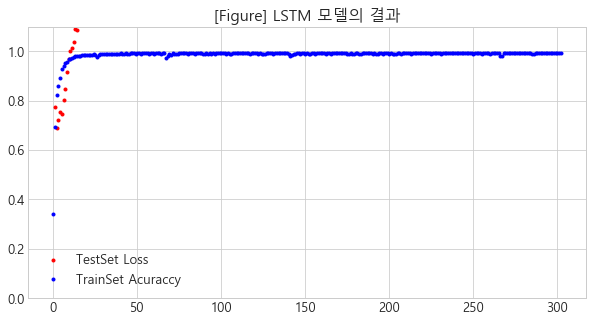

In [34]:
# 테스트셋으로 실험 결과의 오차값을 저장
y_vloss = history.history['val_loss']

# 학습셋으로 측정한 정확도의 값 저장
y_acc = history.history['accuracy']

# x값을 지정하고 그래프로 확인
x_len = np.arange(len(y_acc))
plt.title('[Figure] LSTM 모델의 결과')
plt.plot( x_len, y_vloss, 'o', c='red', markersize=3, label='TestSet Loss')
plt.plot(x_len, y_acc, 'o', c='blue', markersize=3, label='TrainSet Acuraccy')
plt.ylim(0,1.1)
plt.legend()
plt.show()

In [35]:
# 훈련 데이터 정확도
print(model.evaluate(X_train,y_train)[1])

# 테스트 데이터 정확도
print(model.evaluate(X_test, y_test)[1])

95/95 [==============================] - 0s 3ms/step - loss: 0.6890 - accuracy: 0.9096
0.9096305966377258
41/41 [==============================] - 0s 3ms/step - loss: 1.9104 - accuracy: 0.7469
0.7469230890274048


### 7.3 CNN+LSTM

In [36]:
# CNN + LSTM 설정
model = Sequential()
model.add(Embedding( word_size, max_len ) )
model.add(Conv1D(64, 5, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(55))
model.add(Dense(5, activation='softmax')) # 다중분류

# 모델 컴파일
model.compile( loss='categorical_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy']
             )

# 모델 저장 조건 설정
model_path = 'model/CNN+LSTM_0511_2218/{epoch}-{val_loss}.h5'
checkpointer = ModelCheckpoint(filepath=model_path, monitor='val_loss', 
                               verbose=1,
                               save_best_only=True)
# 학습 자동 중단 설정
early_stopping_callback = EarlyStopping(monitor='val_loss',patience=300)

# 훈련 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(padded_x, 
                                                     y_encoded, 
                                                     test_size=0.3, 
                                                     stratify=y_encoded)


# 모델 실행 및 저장
history = model.fit( X_train, y_train, validation_split=0.3,
                    epochs=1500,
                    callbacks=[early_stopping_callback, checkpointer])

Epoch 1/1500
67/67 [==============================] - 3s 12ms/step - loss: 1.4039 - accuracy: 0.3620 - val_loss: 1.0281 - val_accuracy: 0.5791

Epoch 00001: val_loss improved from inf to 1.02806, saving model to model/CNN+LSTM_0511_2218\1-1.0280647277832031.h5
Epoch 2/1500
67/67 [==============================] - 0s 7ms/step - loss: 0.8543 - accuracy: 0.6724 - val_loss: 0.7153 - val_accuracy: 0.7692

Epoch 00002: val_loss improved from 1.02806 to 0.71532, saving model to model/CNN+LSTM_0511_2218\2-0.7153211832046509.h5
Epoch 3/1500
67/67 [==============================] - 0s 7ms/step - loss: 0.4999 - accuracy: 0.8357 - val_loss: 0.6773 - val_accuracy: 0.7692

Epoch 00003: val_loss improved from 0.71532 to 0.67734, saving model to model/CNN+LSTM_0511_2218\3-0.6773353219032288.h5
Epoch 4/1500
67/67 [==============================] - 0s 7ms/step - loss: 0.3603 - accuracy: 0.8866 - val_loss: 0.7029 - val_accuracy: 0.7769

Epoch 00004: val_loss did not improve from 0.67734
Epoch 5/1500
67/6

67/67 [==============================] - 0s 7ms/step - loss: 0.0506 - accuracy: 0.9774 - val_loss: 1.4000 - val_accuracy: 0.7549

Epoch 00042: val_loss did not improve from 0.67734
Epoch 43/1500
67/67 [==============================] - 0s 7ms/step - loss: 0.0464 - accuracy: 0.9820 - val_loss: 1.3753 - val_accuracy: 0.7484

Epoch 00043: val_loss did not improve from 0.67734
Epoch 44/1500
67/67 [==============================] - 1s 8ms/step - loss: 0.0574 - accuracy: 0.9750 - val_loss: 1.4101 - val_accuracy: 0.7538

Epoch 00044: val_loss did not improve from 0.67734
Epoch 45/1500
67/67 [==============================] - 1s 8ms/step - loss: 0.0577 - accuracy: 0.9733 - val_loss: 1.4096 - val_accuracy: 0.7571

Epoch 00045: val_loss did not improve from 0.67734
Epoch 46/1500
67/67 [==============================] - 1s 8ms/step - loss: 0.0541 - accuracy: 0.9767 - val_loss: 1.4172 - val_accuracy: 0.7429

Epoch 00046: val_loss did not improve from 0.67734
Epoch 47/1500
67/67 [==================

67/67 [==============================] - 0s 7ms/step - loss: 0.0447 - accuracy: 0.9774 - val_loss: 1.6004 - val_accuracy: 0.7297

Epoch 00084: val_loss did not improve from 0.67734
Epoch 85/1500
67/67 [==============================] - 0s 7ms/step - loss: 0.0512 - accuracy: 0.9778 - val_loss: 1.5992 - val_accuracy: 0.7275

Epoch 00085: val_loss did not improve from 0.67734
Epoch 86/1500
67/67 [==============================] - 0s 7ms/step - loss: 0.0510 - accuracy: 0.9762 - val_loss: 1.6244 - val_accuracy: 0.7286

Epoch 00086: val_loss did not improve from 0.67734
Epoch 87/1500
67/67 [==============================] - 0s 7ms/step - loss: 0.0443 - accuracy: 0.9794 - val_loss: 1.6100 - val_accuracy: 0.7319

Epoch 00087: val_loss did not improve from 0.67734
Epoch 88/1500
67/67 [==============================] - 1s 8ms/step - loss: 0.0479 - accuracy: 0.9752 - val_loss: 1.6247 - val_accuracy: 0.7341

Epoch 00088: val_loss did not improve from 0.67734
Epoch 89/1500
67/67 [==================


Epoch 00125: val_loss did not improve from 0.67734
Epoch 126/1500
67/67 [==============================] - 1s 9ms/step - loss: 0.0532 - accuracy: 0.9734 - val_loss: 1.7777 - val_accuracy: 0.7231

Epoch 00126: val_loss did not improve from 0.67734
Epoch 127/1500
67/67 [==============================] - 1s 10ms/step - loss: 0.0491 - accuracy: 0.9774 - val_loss: 1.7927 - val_accuracy: 0.7165

Epoch 00127: val_loss did not improve from 0.67734
Epoch 128/1500
67/67 [==============================] - 1s 10ms/step - loss: 0.0445 - accuracy: 0.9762 - val_loss: 1.7900 - val_accuracy: 0.7209

Epoch 00128: val_loss did not improve from 0.67734
Epoch 129/1500
67/67 [==============================] - 1s 10ms/step - loss: 0.0391 - accuracy: 0.9803 - val_loss: 1.8170 - val_accuracy: 0.7165

Epoch 00129: val_loss did not improve from 0.67734
Epoch 130/1500
67/67 [==============================] - 1s 8ms/step - loss: 0.0432 - accuracy: 0.9763 - val_loss: 1.8047 - val_accuracy: 0.7242

Epoch 00130: val


Epoch 00167: val_loss did not improve from 0.67734
Epoch 168/1500
67/67 [==============================] - 1s 8ms/step - loss: 0.0516 - accuracy: 0.9752 - val_loss: 1.9428 - val_accuracy: 0.7055

Epoch 00168: val_loss did not improve from 0.67734
Epoch 169/1500
67/67 [==============================] - 0s 7ms/step - loss: 0.0483 - accuracy: 0.9758 - val_loss: 1.9469 - val_accuracy: 0.7077

Epoch 00169: val_loss did not improve from 0.67734
Epoch 170/1500
67/67 [==============================] - 0s 7ms/step - loss: 0.0408 - accuracy: 0.9816 - val_loss: 1.9387 - val_accuracy: 0.7077

Epoch 00170: val_loss did not improve from 0.67734
Epoch 171/1500
67/67 [==============================] - 0s 7ms/step - loss: 0.0429 - accuracy: 0.9817 - val_loss: 1.9464 - val_accuracy: 0.7099

Epoch 00171: val_loss did not improve from 0.67734
Epoch 172/1500
67/67 [==============================] - 0s 7ms/step - loss: 0.0480 - accuracy: 0.9755 - val_loss: 1.9542 - val_accuracy: 0.7088

Epoch 00172: val_lo


Epoch 00209: val_loss did not improve from 0.67734
Epoch 210/1500
67/67 [==============================] - 0s 7ms/step - loss: 0.0504 - accuracy: 0.9745 - val_loss: 2.0463 - val_accuracy: 0.7000

Epoch 00210: val_loss did not improve from 0.67734
Epoch 211/1500
67/67 [==============================] - 0s 7ms/step - loss: 0.0476 - accuracy: 0.9738 - val_loss: 2.0468 - val_accuracy: 0.7000

Epoch 00211: val_loss did not improve from 0.67734
Epoch 212/1500
67/67 [==============================] - 0s 7ms/step - loss: 0.0482 - accuracy: 0.9769 - val_loss: 2.0536 - val_accuracy: 0.7033

Epoch 00212: val_loss did not improve from 0.67734
Epoch 213/1500
67/67 [==============================] - 1s 9ms/step - loss: 0.0466 - accuracy: 0.9771 - val_loss: 2.0509 - val_accuracy: 0.6967

Epoch 00213: val_loss did not improve from 0.67734
Epoch 214/1500
67/67 [==============================] - 1s 9ms/step - loss: 0.0448 - accuracy: 0.9782 - val_loss: 2.0673 - val_accuracy: 0.7000

Epoch 00214: val_lo


Epoch 00251: val_loss did not improve from 0.67734
Epoch 252/1500
67/67 [==============================] - 0s 7ms/step - loss: 0.0440 - accuracy: 0.9780 - val_loss: 2.0510 - val_accuracy: 0.6923

Epoch 00252: val_loss did not improve from 0.67734
Epoch 253/1500
67/67 [==============================] - 0s 7ms/step - loss: 0.0405 - accuracy: 0.9806 - val_loss: 2.0499 - val_accuracy: 0.6945

Epoch 00253: val_loss did not improve from 0.67734
Epoch 254/1500
67/67 [==============================] - 0s 7ms/step - loss: 0.0410 - accuracy: 0.9799 - val_loss: 2.0609 - val_accuracy: 0.6934

Epoch 00254: val_loss did not improve from 0.67734
Epoch 255/1500
67/67 [==============================] - 0s 7ms/step - loss: 0.0393 - accuracy: 0.9810 - val_loss: 2.0647 - val_accuracy: 0.6934

Epoch 00255: val_loss did not improve from 0.67734
Epoch 256/1500
67/67 [==============================] - 1s 8ms/step - loss: 0.0392 - accuracy: 0.9825 - val_loss: 2.0659 - val_accuracy: 0.6923

Epoch 00256: val_lo


Epoch 00293: val_loss did not improve from 0.67734
Epoch 294/1500
67/67 [==============================] - 1s 8ms/step - loss: 0.0447 - accuracy: 0.9759 - val_loss: 2.2026 - val_accuracy: 0.6879

Epoch 00294: val_loss did not improve from 0.67734
Epoch 295/1500
67/67 [==============================] - 1s 8ms/step - loss: 0.0468 - accuracy: 0.9762 - val_loss: 2.2031 - val_accuracy: 0.6901

Epoch 00295: val_loss did not improve from 0.67734
Epoch 296/1500
67/67 [==============================] - 1s 9ms/step - loss: 0.0412 - accuracy: 0.9798 - val_loss: 2.1987 - val_accuracy: 0.6890

Epoch 00296: val_loss did not improve from 0.67734
Epoch 297/1500
67/67 [==============================] - 1s 8ms/step - loss: 0.0547 - accuracy: 0.9718 - val_loss: 2.2098 - val_accuracy: 0.6901

Epoch 00297: val_loss did not improve from 0.67734
Epoch 298/1500
67/67 [==============================] - 1s 8ms/step - loss: 0.0506 - accuracy: 0.9692 - val_loss: 2.2119 - val_accuracy: 0.6890

Epoch 00298: val_lo

In [37]:
# CNN+LSTM 모델
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 43)          129000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          13824     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 55)                26400     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 280       
Total params: 169,504
Trainable params: 169,504
Non-trainable params: 0
_________________________________________________________________


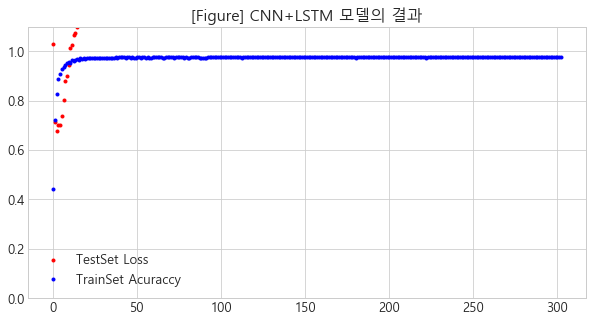

In [38]:
# 테스트셋으로 실험 결과의 오차값을 저장
y_vloss = history.history['val_loss']

# 학습셋으로 측정한 정확도의 값 저장
y_acc = history.history['accuracy']

# x값을 지정하고 그래프로 확인
x_len = np.arange(len(y_acc))
plt.title('[Figure] CNN+LSTM 모델의 결과')
plt.plot( x_len, y_vloss, 'o', c='red', markersize=3, label='TestSet Loss')
plt.plot(x_len, y_acc, 'o', c='blue', markersize=3, label='TrainSet Acuraccy')
plt.ylim(0,1.1)
plt.legend()
plt.show()

In [39]:
# 훈련 데이터 정확도
print(model.evaluate(X_train,y_train)[1])

# 테스트 데이터 정확도
print(model.evaluate(X_test, y_test)[1])

95/95 [==============================] - 0s 3ms/step - loss: 0.6997 - accuracy: 0.8908
0.8908311128616333
41/41 [==============================] - 0s 3ms/step - loss: 2.0208 - accuracy: 0.7015
0.7015384435653687


## 9. 저장한 모델 불러오기
- 1. 테스트 데이터의 정확도가 가장 높고( 0.74) val_loss가 가장 낮은 LSTM 모델 사용
- 2. val_loss가 가장 낮은(0.54) DNN도 사용

In [95]:
best_model = load_model('./model/LSTM_0511_2218/num_words_5000/4-0.6798188090324402.h5')

In [105]:
padded_x = pad_sequences(X, 49)
padded_x # 배열의 길이가 맞춰짐

array([[   0,    0,    0, ...,  682,  877,   59],
       [   0,    0,    0, ..., 1661,  107,   59],
       [   0,    0,    0, ..., 1518, 2362, 4249],
       ...,
       [   0,    0,    0, ...,  752,   30,  580],
       [   0,    0,    0, ...,  829, 3269,   83],
       [   0,    0,    0, ...,    8,  197,  506]])

In [106]:
X_train, X_test, y_train, y_test = train_test_split(padded_x, 
                                                     y_encoded, 
                                                     test_size=0.3, 
                                                     stratify=y_encoded)

In [107]:
# 훈련 데이터 정확도
print(best_model.evaluate(X_train,y_train)[1])

# 테스트 데이터 정확도
print(best_model.evaluate(X_test, y_test)[1])

95/95 [==============================] - 1s 3ms/step - loss: 0.5010 - accuracy: 0.8384
0.8383905291557312
41/41 [==============================] - 0s 3ms/step - loss: 0.4579 - accuracy: 0.8500
0.8500000238418579


## 10. 학습하지 않은 데이터로 후보자 예측

In [108]:
# 학습하지 않은 데이터의 인덱스 번호
null_idx = df2[df2['candidate'].isnull()].index

# 예측 대상인 텍스트 데이터 분리
docs2 = list(df2.iloc[null_idx]['title_comment'])
len(docs2)

139776

In [109]:
# 앞서 만든 토큰의 인덱스로만 채워진 새로운 배열 생성
X2 = token.texts_to_sequences(docs2) 

In [110]:
print(X2[0])
print(docs2[0])

[785, 68, 70, 36, 1659, 1409, 1006, 959, 145, 1770]
재보궐  부산 김영춘  박형준 서울도 양자 대결 철수야 뜸 들이지 말고 애국하는 마음으로 물러서라


In [111]:
# 기존 토큰의 인덱스로 채워진 배열의 값 확인
for key, val  in  token.word_index.items():
    if val in [785, 68, 70, 36, 1659, 1409, 1006, 959, 145, 1770]:
        print(key)

박형준
부산
김영춘
말고
재보궐
철수야
대결
양자
서울도
마음으로


In [112]:
# 패딩
padded_x2 = pad_sequences(X2, 49)
padded_x2.shape

(139776, 49)

In [113]:
# 예측하기
y_pred_label = np.argmax(best_model.predict(padded_x2), axis = 1)
y_pred_label

array([4, 2, 2, ..., 4, 4, 4], dtype=int64)

In [114]:
# 결과 디코딩
y_pred = encoder.inverse_transform(y_pred_label)
y_pred

array(['오세훈', '박영선', '박영선', ..., '오세훈', '오세훈', '오세훈'], dtype=object)

In [115]:
y_pred[10]

'박영선'

In [116]:
docs2[10]

'재보궐  부산 김영춘  박형준 서울도 양자 대결 참 답 없네 학생들 밥 주가 싫다고 생떼 부리다 뛰쳐나간 놈을 뽑기도 그래도'

In [118]:
# 결과값 확인
pd.Series(y_pred).value_counts()

오세훈    91797
박영선    29648
기타     18157
박형준      154
김영춘       20
dtype: int64

In [119]:
# 예측한 후보값 넣기
df2['area_candidate'][null_idx] = y_pred

In [120]:
df2

,area,candidate,candidate_eval,party,party_eval,title_comment,area_candidate
0,NaN,NaN,NaN,NaN,NaN,재보궐 부산 김영춘 박형준 서울도 양자 대결 철수야 뜸 들이지 말고 애국하는 마...,오세훈
1,1.0,1.0,0.0,NaN,NaN,재보궐 부산 김영춘 박형준 서울도 양자 대결 박영선은 정동영이 얻은 프로 선에...,박영선
2,1.0,1.0,0.0,NaN,NaN,재보궐 부산 김영춘 박형준 서울도 양자 대결 빵 산 이가 서울시장 되면 서울은 ...,박영선
3,1.0,1.0,0.0,1.0,0.0,재보궐 부산 김영춘 박형준 서울도 양자 대결 서울시장 후보 더 든 대치어 없음 ...,박영선
4,2.0,NaN,NaN,1.0,0.0,재보궐 부산 김영춘 박형준 서울도 양자 대결 부산은 오거돈 선거이고 오거돈 치부...,박영선
...,...,...,...,...,...,...,...
144134,NaN,NaN,NaN,NaN,NaN,논설위원의 단도직입한 일해져 터널 경제성 없지만 동북아 경제권 차원서 장기 검토해야...,오세훈
144135,NaN,NaN,NaN,NaN,NaN,논설위원의 단도직입한 일해져 터널 경제성 없지만 동북아 경제권 차원서 장기 검토해야...,오세훈
144136,NaN,NaN,NaN,NaN,NaN,논설위원의 단도 직입한 일해저 터널 경제성 없지만 동북아 경제권 차원서 장기 검토해...,오세훈
144137,NaN,NaN,NaN,NaN,NaN,논설위원의 단도 직입한 일해저 터널 경제성 없지만 동북아 경제권 차원서 장기 검토해...,오세훈


In [122]:
df2.to_csv('./data/prediction_byModel2/data_byModel2_0512_0054.csv',encoding='utf-8-sig')